100%|██████████| 26.4M/26.4M [00:01<00:00, 18.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]

Dataset → Train:55000 | Val:5000 | Test:10000


[Ep   1] TrainAcc=0.8263 | ValAcc=0.8668 | TestAcc=0.8689 | Opt=SGD | Δt=22.0s
[Ep   2] TrainAcc=0.8825 | ValAcc=0.8778 | TestAcc=0.8791 | Opt=SGD | Δt=17.4s
[Ep   3] TrainAcc=0.8971 | ValAcc=0.8938 | TestAcc=0.8908 | Opt=SGD | Δt=17.8s
[Ep   4] TrainAcc=0.9091 | ValAcc=0.8914 | TestAcc=0.8894 | Opt=SGD | Δt=17.5s
[Ep   5] TrainAcc=0.8748 | ValAcc=0.8316 | TestAcc=0.8289 | Opt=ADAM | Δt=17.7s
[Ep   6] TrainAcc=0.9117 | ValAcc=0.9026 | TestAcc=0.9019 | Opt=SAM | Δt=23.2s
[Ep   7] TrainAcc=0.8948 | ValAcc=0.8856 | TestAcc=0.8782 | Opt=ADAM | Δt=17.8s
[Ep   8] TrainAcc=0.9005 | ValAcc=0.8830 | TestAcc=0.8782 | Opt=ADAM | Δt=18.1s
[Ep   9] TrainAcc=0.9042 | ValAcc=0.8926 | TestAcc=0.8912 | Opt=ADAM | Δt=17.7s
[Ep  10] TrainAcc=0.9255 | ValAcc=0.9150 | TestAcc=0.9102 | Opt=SAM | Δt=22.9s
[Ep  11] TrainAcc=0.9342 | ValAcc=0.9194 | TestAcc=0.9156 | Opt=SGD | Δt=17.7s
[Ep  12] TrainAcc=0.9096 | ValAcc=0.8916 | TestAcc=0.8960 | Opt=ADAM | Δt=17.9s
[Ep  13] TrainAcc=0.9117 | ValAcc=0.8782 | Test

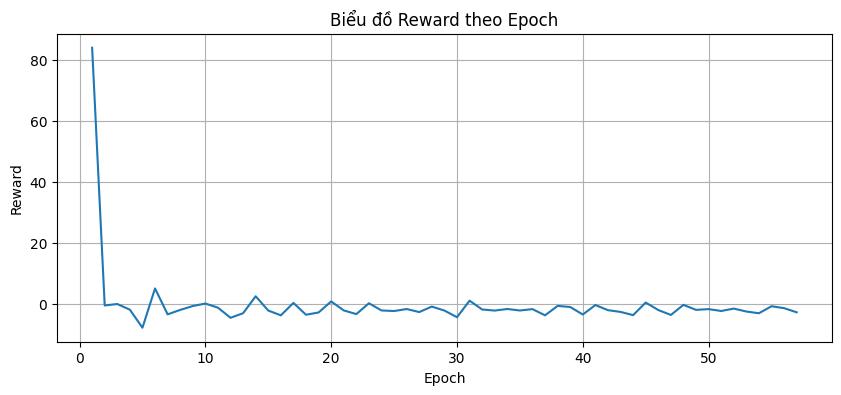

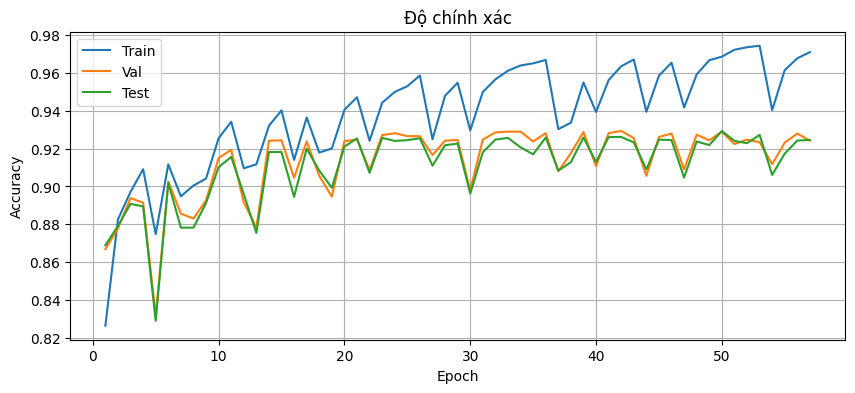

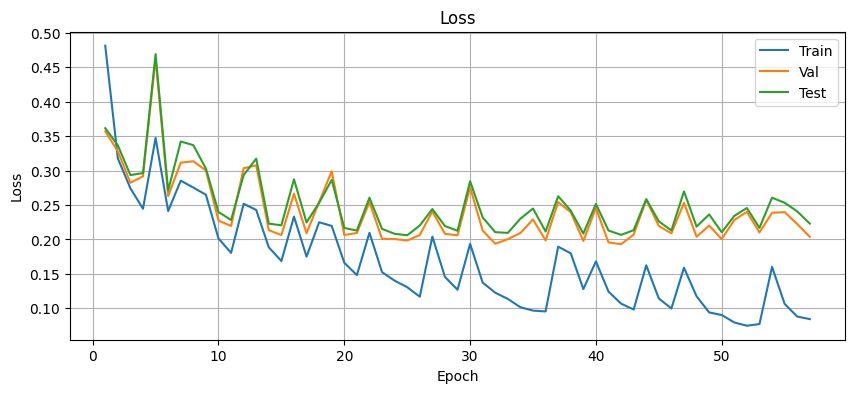


===== CHỈ SỐ CUỐI CÙNG =====
Accuracy  : 0.9262
F1 Score  : 0.9264
Precision : 0.9268

===== BEST VALIDATION CHECKPOINT =====
Epoch        : 42
Best ValAcc  : 0.9294
Best TestAcc : 0.9262
Best TestLoss: 0.2067


In [2]:
# =============================================================
# optimizer_rl_selector.py  — v19.6 (chuyển sang FashionMNIST)
# -------------------------------------------------------------
#  • Dataset : FashionMNIST (train / val / test) với augmentation
#  • Model   : ResNet-18 (huấn luyện từ đầu)
#  • RL      : PPO chọn optimizer {SGD, Adam, SAM}
#  • Reward  : 100·ΔAcc – ΔLoss – 0.1·epoch_time + 50·FinalAcc
# -------------------------------------------------------------
# Thay đổi v19.6:
#   • Chuyển dataset từ CIFAR-10 sang FashionMNIST

import math
import random
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
from torch import optim
from sklearn.metrics import accuracy_score, f1_score, precision_score

from torchvision.datasets import FashionMNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

import builtins
import functools
print = functools.partial(builtins.print, flush=True)

# ------------------------------ 0. Tham số cấu hình -------------------
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED          = 42
ROLLOUT_STEPS = 4
GAMMA         = 0.99
LAMBDA_GAE    = 0.95
PPO_EPOCHS    = 4
CLIP_EPS      = 0.2
ENT_COEF      = 2e-2
LR_POLICY     = 3e-4
LR_VALUE      = 1e-3
STATE_DIM     = 8    # [val_acc, val_loss, Δacc, Δloss, epoch%, prev_act_onehot*3]
ACTION_DIM    = 3    # 0=SGD, 1=Adam, 2=SAM

W_ACC, W_LOSS, W_TIME = 100.0, 1.0, 0.1
FINAL_BONUS_W         = 50.0
LOSS_SCALE            = 2.0
WEIGHT_DECAY          = 5e-4

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ------------------------------ 1. SAM tuỳ chỉnh ----------------------
class SAM(optim.Optimizer):
    """Sharpness-Aware Minimization (hai bước) bỏ qua khi grad nhỏ"""
    def __init__(self, params, base_optimizer, rho=0.05, grad_norm_eps=1e-12, **kwargs):
        super().__init__(params, dict(rho=rho, grad_norm_eps=grad_norm_eps, **kwargs))
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = torch.norm(torch.stack([
            p.grad.norm() for g in self.param_groups for p in g['params'] if p.grad is not None
        ]))
        if grad_norm < self.defaults['grad_norm_eps']:
            return
        for g in self.param_groups:
            scale = g['rho'] / (grad_norm + 1e-12)
            for p in g['params']:
                if p.grad is None: continue
                e_w = p.grad * scale
                p.add_(e_w)
                self.state[p]['e_w'] = e_w.detach()
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for g in self.param_groups:
            for p in g['params']:
                if p.grad is None: continue
                p.sub_(self.state[p]['e_w'])
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

# ------------------------------ 2. Model ------------------------------
def get_resnet18_scratch(num_classes=10):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ------------------------------ 3. Dữ liệu ----------------------------
def load_fashion_mnist(batch_train=128, batch_eval=256):
    # Resize to 32x32 and convert 1-channel to 3-channel for ResNet
    tf_train = T.Compose([
        T.Resize(32),
        T.Grayscale(num_output_channels=3),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])
    tf_eval = T.Compose([
        T.Resize(32),
        T.Grayscale(num_output_channels=3),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])

    full_train = FashionMNIST(
        root='./data', train=True, download=True, transform=tf_train
    )
    test_set   = FashionMNIST(
        root='./data', train=False, download=True, transform=tf_eval
    )

    n_val = 5000
    train_ds, val_ds = random_split(
        full_train,
        [len(full_train)-n_val, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )

    dl_train = DataLoader(train_ds, batch_size=batch_train, shuffle=True,  num_workers=2, pin_memory=True)
    dl_val   = DataLoader(val_ds,   batch_size=batch_eval,  shuffle=False, num_workers=2, pin_memory=True)
    dl_test  = DataLoader(test_set, batch_size=batch_eval,  shuffle=False, num_workers=2, pin_memory=True)

    print(f"Dataset → Train:{len(train_ds)} | Val:{len(val_ds)} | Test:{len(test_set)}")
    return dl_train, dl_val, dl_test

# ------------------------------ 4. Mạng RL ----------------------------
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM,64), nn.Tanh(),
            nn.Linear(64,64), nn.Tanh(),
            nn.Linear(64,ACTION_DIM)
        )
    def forward(self,x): return self.net(x)

class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM,64), nn.Tanh(),
            nn.Linear(64,64), nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.net(x).squeeze(-1)

# ------------------------------ 5. RolloutBuffer ----------------------
class RolloutBuffer:
    def __init__(self): self.clear()
    def store(self,s,a,logp,v,r,d):
        self.states.append(s.detach()); self.actions.append(a.detach()); self.logprobs.append(logp.detach())
        self.values.append(v.detach()); self.rewards.append(
            r.detach() if isinstance(r,torch.Tensor) else torch.tensor(r,dtype=torch.float32,device=DEVICE)
        )
        self.dones.append(torch.tensor(d,dtype=torch.float32,device=DEVICE))
    def compute(self,next_value):
        self.advs,self.rets=[],[]; adv=0.0
        for i in reversed(range(len(self.rewards))):
            mask = 1.0 - self.dones[i]
            delta = self.rewards[i] + GAMMA*next_value*mask - self.values[i]
            adv   = delta + GAMMA*LAMBDA_GAE*mask*adv
            self.advs.insert(0,adv); self.rets.insert(0,adv+self.values[i])
            next_value = self.values[i]
    def as_tensors(self):
        stk=lambda x: x if isinstance(x,torch.Tensor) else torch.stack(x)
        return (stk(self.states).to(DEVICE),stk(self.actions).to(DEVICE),stk(self.logprobs).to(DEVICE),stk(self.advs).to(DEVICE),stk(self.rets).to(DEVICE))
    def clear(self): self.states,self.actions,self.logprobs,self.values,self.rewards,self.dones,self.advs,self.rets=[[] for _ in range(8)]

# ------------------------------ 6. Optimizer factory -------------------
ID2OPT=['sgd','adam','sam']
def make_optimizer(name,model,lr):
    if name=='sgd': return optim.SGD(model.parameters(),lr=lr,momentum=0.9,weight_decay=WEIGHT_DECAY)
    if name=='adam':return optim.Adam(model.parameters(),lr=lr,weight_decay=WEIGHT_DECAY)
    if name=='sam': return SAM(model.parameters(),base_optimizer=optim.SGD,lr=lr,momentum=0.9,weight_decay=WEIGHT_DECAY)
    raise ValueError(name)

# ------------------------------ 7. Trainer -----------------------------
class OptimizerRLTrainer:
    def __init__(self,model,dl_train,dl_val,dl_test,n_epochs=150,patience=15):
        self.model,self.dl_train,self.dl_val,self.dl_test=model.to(DEVICE),dl_train,dl_val,dl_test;self.n_epochs,self.patience=n_epochs,patience
        self.policy,self.value=PolicyNet().to(DEVICE),ValueNet().to(DEVICE)
        self.opt_policy,self.opt_value=optim.Adam(self.policy.parameters(),lr=LR_POLICY),optim.Adam(self.value.parameters(),lr=LR_VALUE)
        self.opt_pool={k:make_optimizer(k,self.model,1e-3 if k=='adam' else 1e-2) for k in ID2OPT}
        self.hist={k:[] for k in ['train_acc','val_acc','test_acc','train_loss','val_loss','test_loss','reward','action']}
        self.best_val,self.best_epoch,self.best_test_acc,self.best_test_loss,self.best_state=0.0,0,0.0,0.0,None

    def _eval(self, loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        tot_loss, tot_correct, n = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = self.model(x)
                loss = loss_fn(logits, y)
                tot_loss    += loss.item() * y.size(0)
                tot_correct += (logits.argmax(1) == y).sum().item()
                n += y.size(0)
        return tot_correct/n, tot_loss/n

    def _ppo(self, buf):
        states, actions, old_logp, advs, rets = buf.as_tensors()
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        for _ in range(PPO_EPOCHS):
            dist       = tdist.Categorical(logits=self.policy(states))
            logp       = dist.log_prob(actions)
            ratio      = torch.exp(logp - old_logp)
            surr1      = ratio * advs
            surr2      = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advs
            policy_loss= -(torch.min(surr1, surr2) + ENT_COEF * dist.entropy()).mean()

            self.opt_policy.zero_grad()
            policy_loss.backward()
            self.opt_policy.step()

            value_pred = self.value(states)
            value_loss = F.mse_loss(value_pred, rets)

            self.opt_value.zero_grad()
            value_loss.backward()
            self.opt_value.step()

    def fit(self):
        loss_fn = nn.CrossEntropyLoss()
        buf     = RolloutBuffer()
        prev_acc, prev_loss, prev_act, pat_cnt = 0.0, 0.0, 0, 0

        for ep in range(self.n_epochs):
            start = time.time()
            self.model.train()

            state = torch.tensor([
                prev_acc,
                prev_loss / LOSS_SCALE,
                0.0,
                0.0,
                ep / self.n_epochs,
                *[int(prev_act == i) for i in range(ACTION_DIM)]
            ], dtype=torch.float32, device=DEVICE)

            dist     = tdist.Categorical(logits=self.policy(state))
            act      = dist.sample()
            logp     = dist.log_prob(act)
            opt_name = ID2OPT[act.item()]
            optimizer= self.opt_pool[opt_name]

            # ----- Huấn luyện một epoch -----
            tot_loss, tot_correct, n = 0.0, 0, 0
            for x, y in self.dl_train:
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                logits = self.model(x)
                loss   = loss_fn(logits, y)

                if opt_name == 'sam':
                    loss.backward()
                    optimizer.first_step(zero_grad=True)
                    loss_sam = loss_fn(self.model(x), y)
                    loss_sam.backward()
                    optimizer.second_step(zero_grad=True)
                else:
                    loss.backward()
                    optimizer.step()

                tot_loss    += loss.item() * y.size(0)
                tot_correct += (logits.argmax(1) == y).sum().item()
                n += y.size(0)

            train_acc  = tot_correct / n
            train_loss = tot_loss / n

            # ----- Đánh giá sau epoch -----
            val_acc, val_loss   = self._eval(self.dl_val)
            test_acc, test_loss = self._eval(self.dl_test)

            # ----- Checkpoint Best Val -----
            if val_acc > self.best_val:
                self.best_val       = val_acc
                self.best_epoch     = ep + 1
                self.best_test_acc  = test_acc
                self.best_test_loss = test_loss
                self.best_state     = copy.deepcopy(self.model.state_dict())
                pat_cnt = 0
            else:
                pat_cnt += 1

            # ----- Tính reward và store -----
            delta_acc  = val_acc - prev_acc
            delta_loss = prev_loss - val_loss
            elapsed    = time.time() - start
            r          = W_ACC * delta_acc + W_LOSS * delta_loss - W_TIME * elapsed
            if ep == self.n_epochs - 1:
                r += FINAL_BONUS_W * val_acc

            buf.store(
                state,
                act,
                logp,
                self.value(state).detach(),
                torch.tensor(r, dtype=torch.float32, device=DEVICE),
                ep == self.n_epochs - 1
            )

            if (ep + 1) % ROLLOUT_STEPS == 0 or ep == self.n_epochs - 1:
                buf.compute(torch.tensor(0.0, device=DEVICE))
                self._ppo(buf)
                buf.clear()

            # ----- Lưu lịch sử -----
            for k, v in zip(
                ['train_acc','val_acc','test_acc','train_loss','val_loss','test_loss'],
                [train_acc, val_acc, test_acc, train_loss, val_loss, test_loss]
            ):
                self.hist[k].append(v)
            self.hist['reward'].append(r)
            self.hist['action'].append(act.item())

            # ----- In log epoch -----
            print(
                f"[Ep {ep+1:3}] TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} | "
                f"TestAcc={test_acc:.4f} | Opt={opt_name.upper()} | Δt={elapsed:.1f}s"
            )

            # ----- Early stopping -----
            if pat_cnt >= self.patience:
                print(f"Dừng sớm tại epoch {ep+1}")
                break

            prev_acc, prev_loss, prev_act = val_acc, val_loss, act.item()

        # ----- In bảng Reward -----
        reward_df = pd.DataFrame({
            'Epoch': list(range(1, len(self.hist['reward'])+1)),
            'Reward': self.hist['reward']
        })

        print("\n===== BẢNG REWARD =====")
        print(reward_df.to_string(index=False))

        # ----- Vẽ Reward theo Epoch -----
        plt.figure(figsize=(10, 4))
        plt.plot(reward_df['Epoch'], reward_df['Reward'], label='Reward')
        plt.title('Biểu đồ Reward theo Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Reward')
        plt.grid()
        plt.show()

        # ----- Plot Accuracy & Loss -----
        epochs = list(range(1, len(self.hist['train_acc'])+1))

        plt.figure(figsize=(10, 4))
        plt.plot(epochs, self.hist['train_acc'], label='Train')
        plt.plot(epochs, self.hist['val_acc'],   label='Val')
        plt.plot(epochs, self.hist['test_acc'],  label='Test')
        plt.title('Độ chính xác')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(epochs, self.hist['train_loss'], label='Train')
        plt.plot(epochs, self.hist['val_loss'],   label='Val')
        plt.plot(epochs, self.hist['test_loss'],  label='Test')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

        # ----- Chỉ số cuối cùng -----
        self.model.load_state_dict(self.best_state)
        self.model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for x, y in self.dl_test:
                x, y = x.to(DEVICE), y.to(DEVICE)
                preds.append(self.model(x).argmax(1).cpu())
                labels.append(y.cpu())
        preds, labels = torch.cat(preds), torch.cat(labels)

        acc  = accuracy_score(labels, preds)
        f1_  = f1_score(labels, preds, average='weighted')
        prec = precision_score(labels, preds, average='weighted')

        print("\n===== CHỈ SỐ CUỐI CÙNG =====")
        print(f"Accuracy  : {acc:.4f}")
        print(f"F1 Score  : {f1_:.4f}")
        print(f"Precision : {prec:.4f}")

        # ----- Best checkpoint metrics -----
        if self.best_state is not None:
            print("\n===== BEST VALIDATION CHECKPOINT =====")
            print(f"Epoch        : {self.best_epoch}")
            print(f"Best ValAcc  : {self.best_val:.4f}")
            print(f"Best TestAcc : {self.best_test_acc:.4f}")
            print(f"Best TestLoss: {self.best_test_loss:.4f}")

# ------------------------------ 8. Main ------------------------------
# ------------------------------ 8. Main ------------------------------
if __name__ == '__main__':
    # Dùng FashionMNIST thay cho CIFAR10
    dl_train, dl_val, dl_test = load_fashion_mnist()

    model   = get_resnet18_scratch()
    trainer = OptimizerRLTrainer(
        model,
        dl_train,
        dl_val,
        dl_test,
        n_epochs=150,
        patience=15
    )
    trainer.fit()
